In [1]:
import os
import csv
import kornia as K
import numpy as np
import torch
from tqdm import tqdm

from utils import convert_image_to_tensor
from metrics import mse_masked, local_ncc_masked, nmi_masked, ssim_masked, iou, hausdorff
from DatasetTools.LeafImageSeries import LeafDataset
from registration import fetch_registered_image_mask_seq

import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="monai"
)

<frozen importlib._bootstrap_external>:1325: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
/layers/paketo-buildpacks_conda-env-update/conda-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# if __name__ == "__main__":
# out_file = "test.csv"
out_file = "seq_registration.csv"

metrics = {'MSE': mse_masked, 'NCC': local_ncc_masked, 'MI': nmi_masked, 'SSIM': ssim_masked, 'IoU': iou, 'Hausdorff': hausdorff}

registration_methods = ["Piecewise Affine", "LoFTR + TPS Individual", "LoFTR + TPS Semi-Sequential"]#, "LoFTR + TPS ROI with Markers"]
leaf_styles = ["Leaf ROI"]
data_to_load = []
if "Piecewise Affine" in registration_methods:
    data_to_load.extend(['target_images', 'target_masks'])
if "Leaf ROI" in leaf_styles or "Leaf ROI with Markers" in leaf_styles or "Leaf ROI Pre-Rotated" in leaf_styles or "Leaf ROI Pre-Rotated with Markers" in leaf_styles:
    data_to_load.extend(['roi_leaf_masks'])
if "Full Leaf" in leaf_styles or "Full Leaf with Markers" in leaf_styles:
    data_to_load.extend(['seg_masks', 'cropped_images'])

# fetch list of all leaf uids
base_dir = '../leaf-image-sequences'
assert os.path.exists(base_dir+'/raw'), "Base directory empty" 
uid_dir = base_dir + '/processed/reg'
leaf_uids = [
    name for name in os.listdir(uid_dir)
    if os.path.isdir(os.path.join(uid_dir, name))
]   


# track which leaves have been evaluated for which metrics
processed_keys = set()
if os.path.exists(out_file):
    with open(out_file, newline="", mode="r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            key = (row["leaf_uid"], row["registration_method"], row["leaf_style"])
            processed_keys.add(key)

with open(out_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['leaf_uid', 'registration_method', 'leaf_style', 'fixed_image', 'moving_image']+list(metrics.keys()))
    
    # write header only if file is new
    if f.tell() == 0:
        writer.writeheader()

    # iterate through all leaves
    for uid in leaf_uids:

        # skip leaves that have been evaluated for all methods
        keys_to_check = [ (uid, method, style) for method in registration_methods for style in leaf_styles]
        if all(key in processed_keys for key in keys_to_check):
            print(f"Leaf {uid} has been processed for all registration methods")
            continue
        
        # load leaf
        leaf = LeafDataset(
            base_dir=base_dir,
            leaf_uid=uid, 
            load=data_to_load,
            verbose=False
        )  

    

        for style in leaf_styles:
            for method in registration_methods:

                # skip leaves that have already been evaluated for this method
                key = (uid, method, style)
                if key in processed_keys:
                    print(f"Leaf {uid} has already been evaluated for {method} registration.")
                    continue
                else:
                    print(f"Evaluating {method} registration on leaf {uid}...")

                imgs, masks = fetch_registered_image_mask_seq(leaf, method, style)

                fixed_img_indices = [0] #,1]
                moving_img_indices = np.arange(1,leaf.n_leaves)

                # iterate through fixed and moving indices
                for fixed_img_ind in fixed_img_indices:
                    fixed_img = imgs[fixed_img_ind]
                    fixed_mask = masks[fixed_img_ind]

                    for moving_img_ind in tqdm(moving_img_indices):

                        # fixed_img, moving_img, fixed_mask, moving_mask = fetch_registered_image_mask_pair(leaf, fixed_img_ind, moving_img_ind, method)
                        
                        eval_res = {'leaf_uid': uid, 'registration_method': method, 'leaf_style': style, 'fixed_image': fixed_img_ind, 'moving_image': moving_img_ind}

                        moving_img = imgs[moving_img_ind]
                        moving_mask = masks[moving_img_ind]
                        if (fixed_img is None) or (moving_img is None) or (fixed_mask is None) or (moving_mask is None):
                            print(f"Error: missing data for leaf {uid}")
                            for metric_name, metric_func in metrics.items():
                                eval_res.update({metric_name: None})    
                            writer.writerow(eval_res)
                            continue                    

                        # evaluate for all metrics
                        for metric_name, metric_func in metrics.items():
                            val = metric_func(fixed_img, fixed_mask, moving_img, moving_mask)
                            eval_res.update({metric_name: val.item()})

                        # write data to output
                        writer.writerow(eval_res)


Leaf ESWW0070020_1 has been processed for all registration methods
Leaf ESWW0070020_10 has been processed for all registration methods
Leaf ESWW0070020_2 has been processed for all registration methods
Leaf ESWW0070020_3 has been processed for all registration methods
Leaf ESWW0070020_4 has been processed for all registration methods
Leaf ESWW0070020_5 has been processed for all registration methods
Leaf ESWW0070020_6 has been processed for all registration methods
Leaf ESWW0070020_7 has been processed for all registration methods
Leaf ESWW0070020_8 has been processed for all registration methods
Leaf ESWW0070020_9 has been processed for all registration methods
Leaf ESWW0070023_1 has been processed for all registration methods
Leaf ESWW0070023_10 has been processed for all registration methods
Leaf ESWW0070023_2 has been processed for all registration methods
Leaf ESWW0070023_3 has been processed for all registration methods
Leaf ESWW0070023_4 has been processed for all registration m

Processing series:  12%|█▏        | 2/17 [00:01<00:14,  1.06it/s]


OSError: [Errno 107] Transport endpoint is not connected

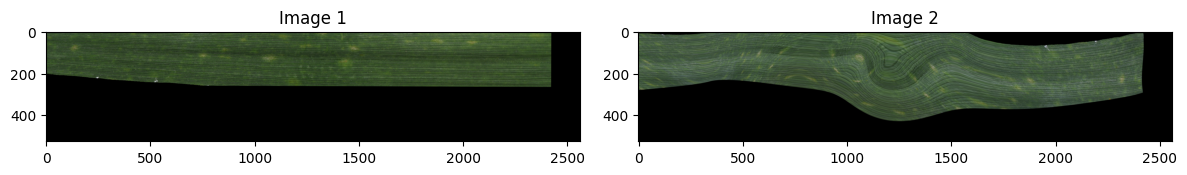

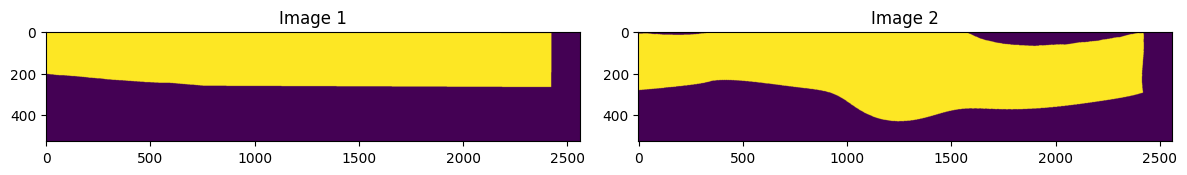

In [28]:
from plotting import plot_image_pair

_ = plot_image_pair(imgs[0], imgs[1])
_ = plot_image_pair(masks[0], masks[1])

Computing Metrics:   7%|▋         | 1/14 [00:00<00:07,  1.81it/s]

{'MSE': 0.009408139623701572, 'NCC': 0.011984247714281082, 'MI': 1.0001561641693115, 'SSIM': 0.5308004021644592, 'IoU': 0.7192675471305847, 'Hausdorff': 160.0}


Computing Metrics:  14%|█▍        | 2/14 [00:01<00:06,  1.87it/s]

{'MSE': 0.008163410238921642, 'NCC': 0.08702656626701355, 'MI': 1.0153775215148926, 'SSIM': 0.69334477186203, 'IoU': 0.9625295996665955, 'Hausdorff': 24.0}


Computing Metrics:  21%|██▏       | 3/14 [00:01<00:05,  1.87it/s]

{'MSE': 0.01012022327631712, 'NCC': 0.005170757882297039, 'MI': 1.0075461864471436, 'SSIM': 0.6772794723510742, 'IoU': 0.9688186645507812, 'Hausdorff': 10.0}


Computing Metrics:  29%|██▊       | 4/14 [00:02<00:05,  1.96it/s]

{'MSE': 0.0064186472445726395, 'NCC': 0.09911404550075531, 'MI': 1.0191502571105957, 'SSIM': 0.7029111385345459, 'IoU': 0.9786729216575623, 'Hausdorff': 6.0}


Computing Metrics:  36%|███▌      | 5/14 [00:02<00:04,  2.00it/s]

{'MSE': 0.02900676056742668, 'NCC': 0.11850250512361526, 'MI': 1.0197371244430542, 'SSIM': 0.6919086575508118, 'IoU': 0.9665870070457458, 'Hausdorff': 11.0}


Computing Metrics:  43%|████▎     | 6/14 [00:03<00:03,  2.04it/s]

{'MSE': 0.013653473928570747, 'NCC': 0.1074591726064682, 'MI': 1.0151712894439697, 'SSIM': 0.6990343332290649, 'IoU': 0.9705379605293274, 'Hausdorff': 10.049875259399414}


Computing Metrics:  50%|█████     | 7/14 [00:03<00:03,  2.05it/s]

{'MSE': 0.06228142976760864, 'NCC': 0.04216259345412254, 'MI': 1.0085145235061646, 'SSIM': 0.6255151033401489, 'IoU': 0.9253687858581543, 'Hausdorff': 123.0}


Computing Metrics:  57%|█████▋    | 8/14 [00:04<00:02,  2.04it/s]

{'MSE': 0.022781865671277046, 'NCC': 0.08062516152858734, 'MI': 1.0060806274414062, 'SSIM': 0.695218026638031, 'IoU': 0.9802374839782715, 'Hausdorff': 6.7082037925720215}


Computing Metrics:  64%|██████▍   | 9/14 [00:04<00:02,  2.03it/s]

{'MSE': 0.021125400438904762, 'NCC': 0.11207757145166397, 'MI': 1.0096020698547363, 'SSIM': 0.7211548686027527, 'IoU': 0.9820865392684937, 'Hausdorff': 5.0}


Computing Metrics:  71%|███████▏  | 10/14 [00:05<00:02,  1.96it/s]

{'MSE': 0.023397698998451233, 'NCC': 0.002046037930995226, 'MI': 1.0030815601348877, 'SSIM': 0.6223477721214294, 'IoU': 0.7360036373138428, 'Hausdorff': 253.0303497314453}


/home/renku/work/LeafAlignment/plotting.py:322: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(12,6))
Computing Metrics:  79%|███████▊  | 11/14 [00:05<00:01,  2.00it/s]

{'MSE': 0.022576753050088882, 'NCC': 0.07040184736251831, 'MI': 1.0079363584518433, 'SSIM': 0.6724060773849487, 'IoU': 0.9701753854751587, 'Hausdorff': 9.0}


Computing Metrics:  86%|████████▌ | 12/14 [00:06<00:00,  2.02it/s]

{'MSE': 0.01915859989821911, 'NCC': 0.1491861492395401, 'MI': 1.0085939168930054, 'SSIM': 0.6867510676383972, 'IoU': 0.9781090021133423, 'Hausdorff': 8.0}


Computing Metrics:  93%|█████████▎| 13/14 [00:06<00:00,  2.02it/s]

{'MSE': 0.039656005799770355, 'NCC': 0.016979126259684563, 'MI': 1.0028369426727295, 'SSIM': 0.6463425755500793, 'IoU': 0.9481114745140076, 'Hausdorff': 29.0}


Computing Metrics: 100%|██████████| 14/14 [00:07<00:00,  2.00it/s]

{'MSE': 0.011387008242309093, 'NCC': 0.011542363092303276, 'MI': 1.0020400285720825, 'SSIM': 0.6761360764503479, 'IoU': 0.9223542213439941, 'Hausdorff': 45.0}


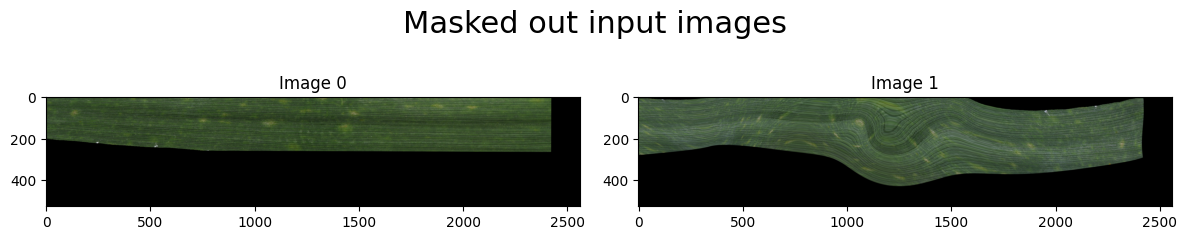

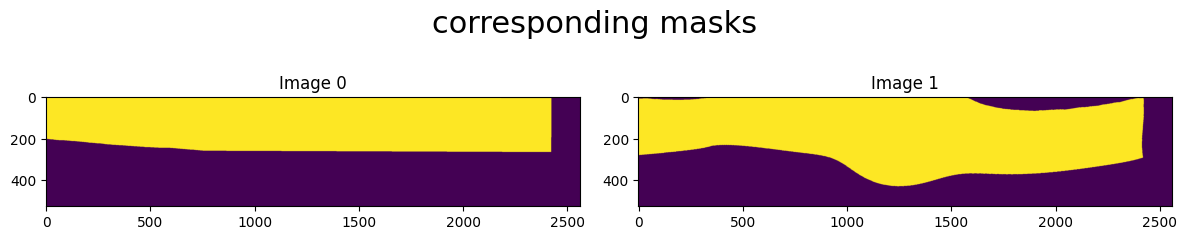

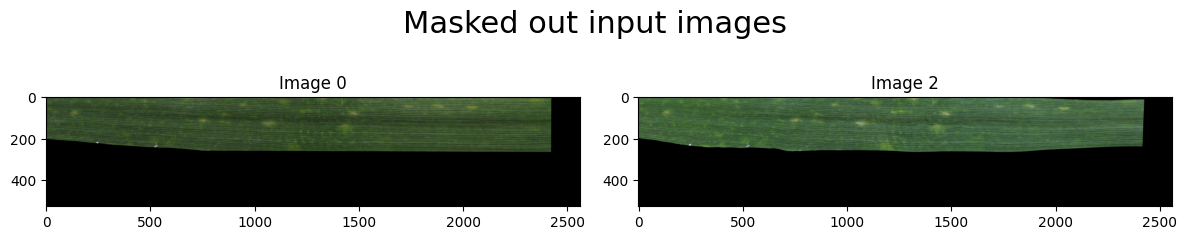

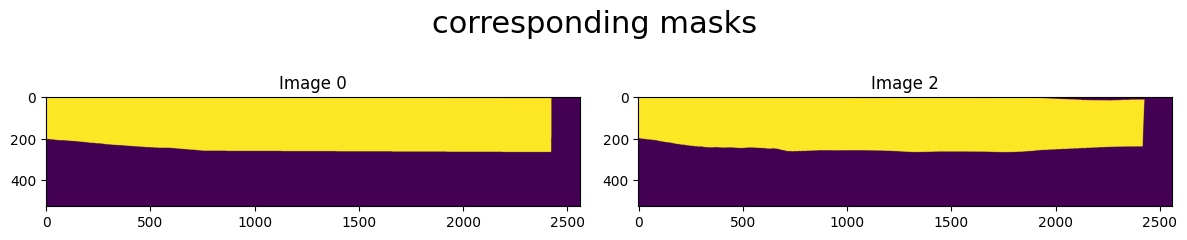

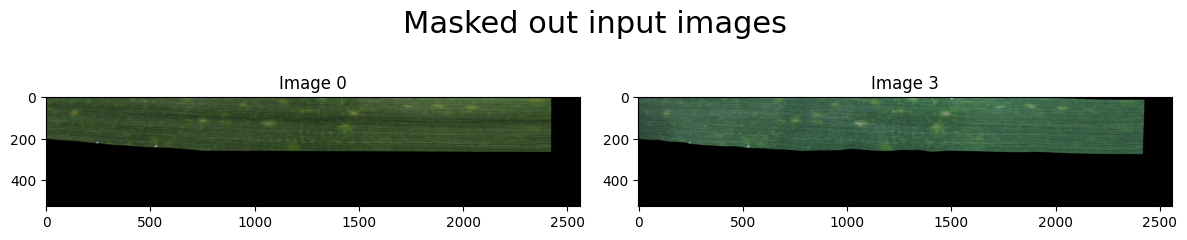

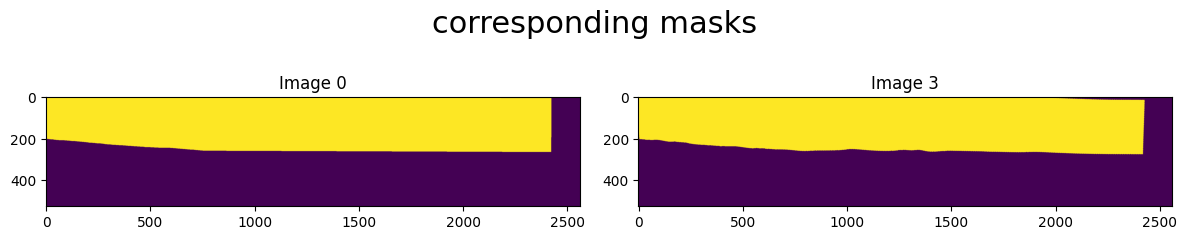

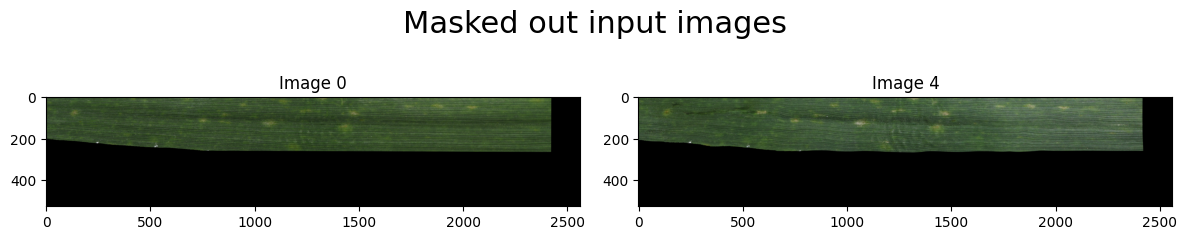

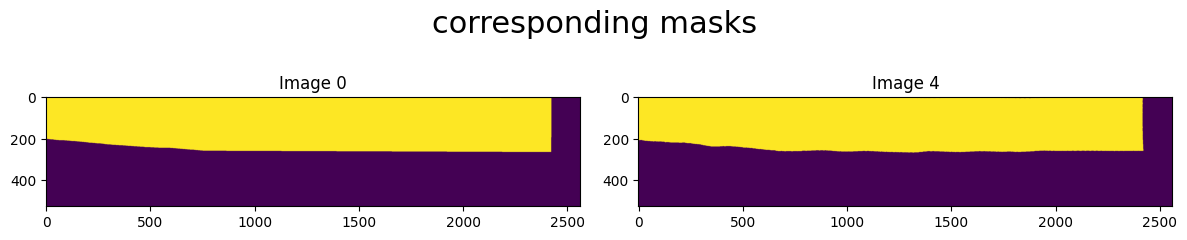

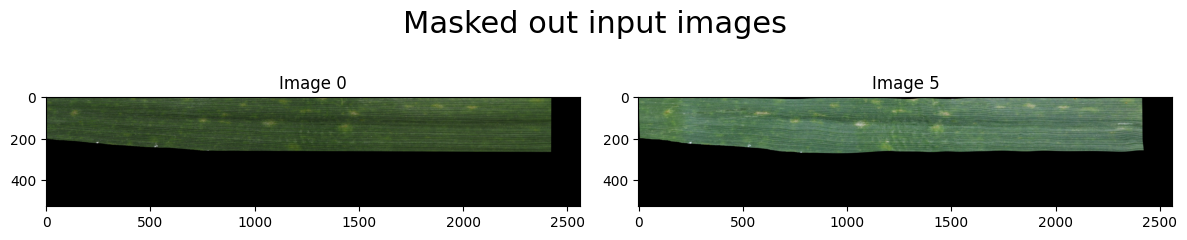

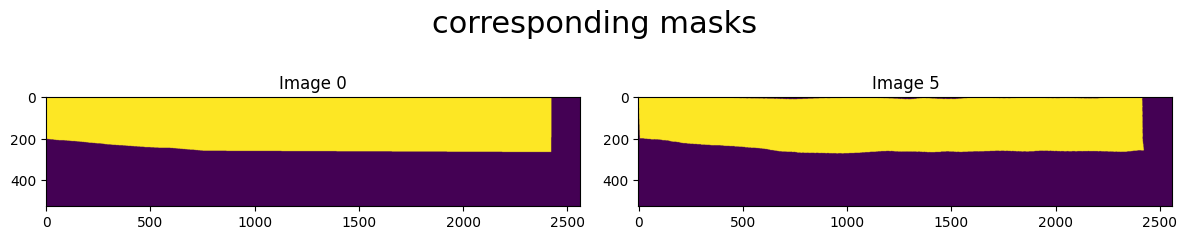

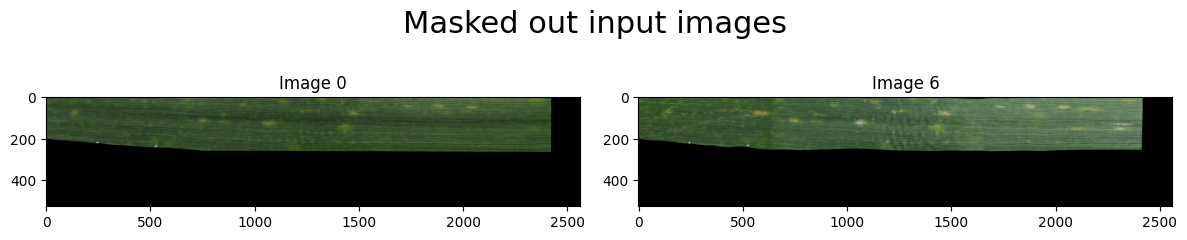

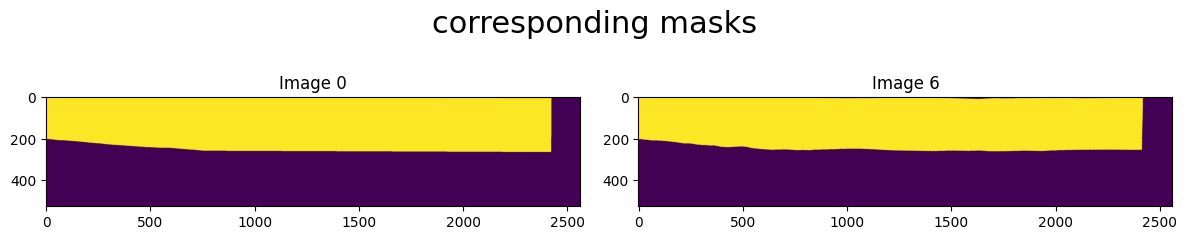

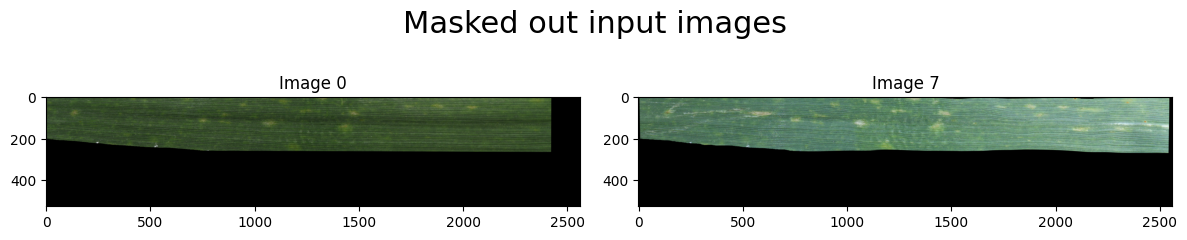

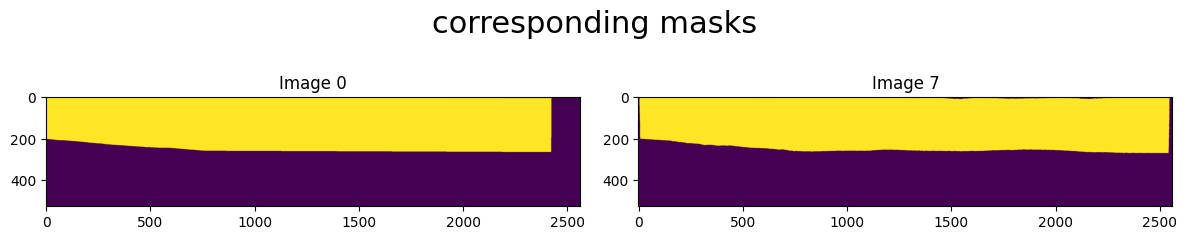

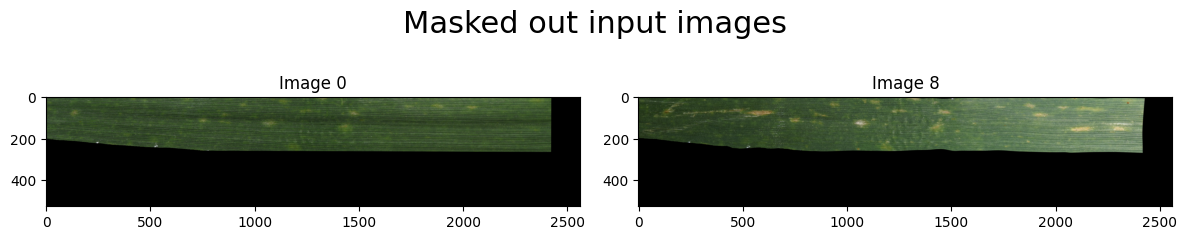

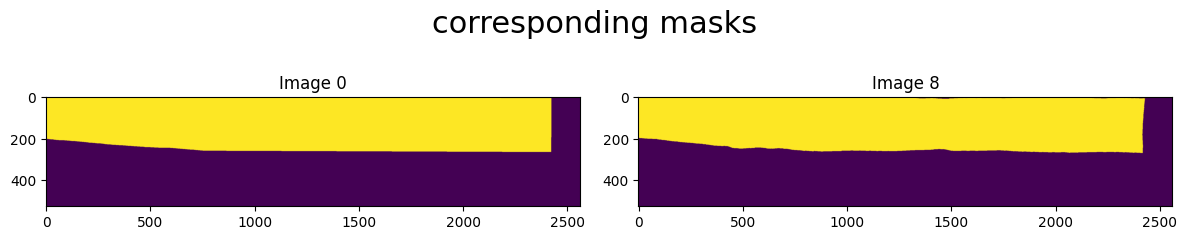

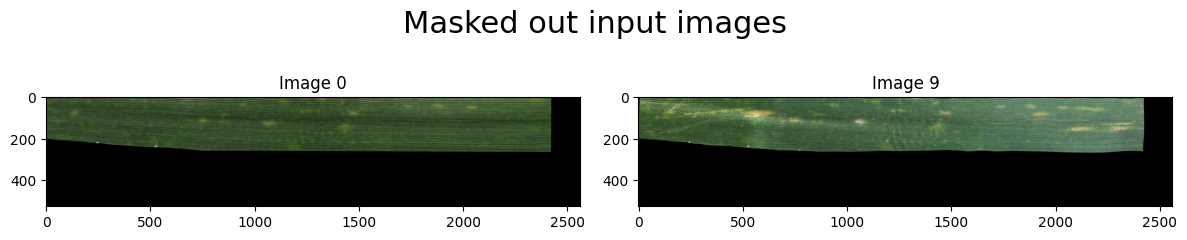

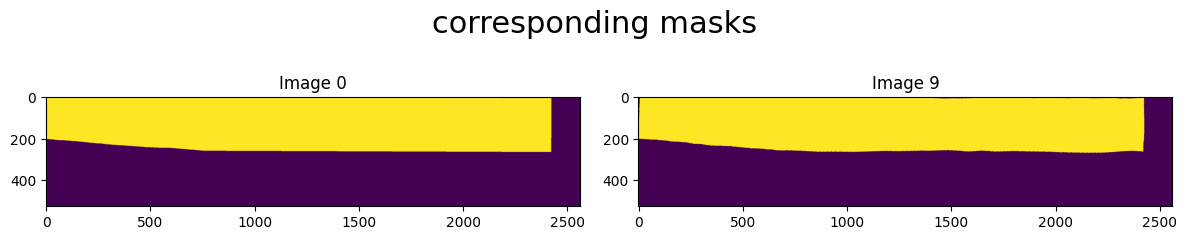

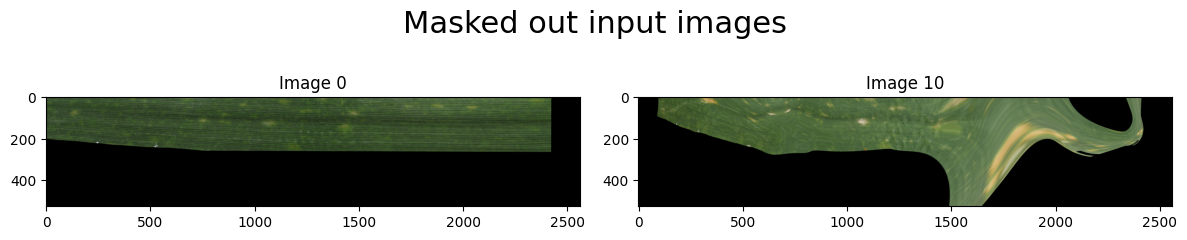

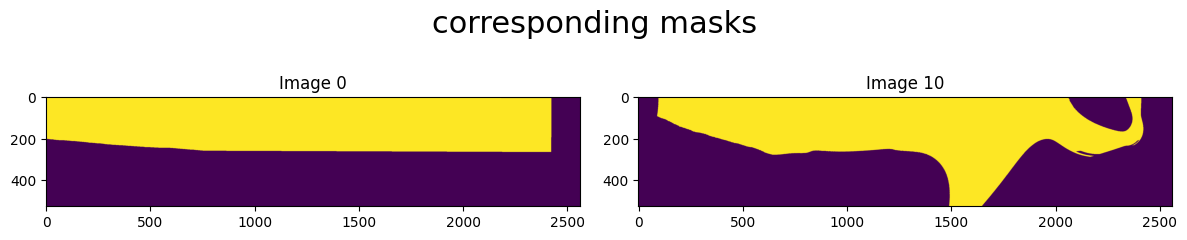

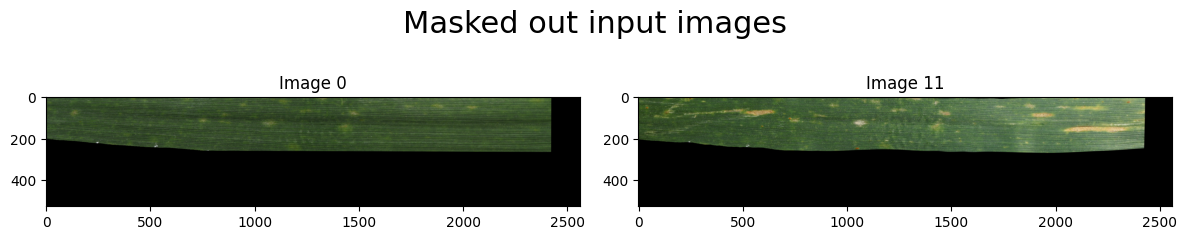

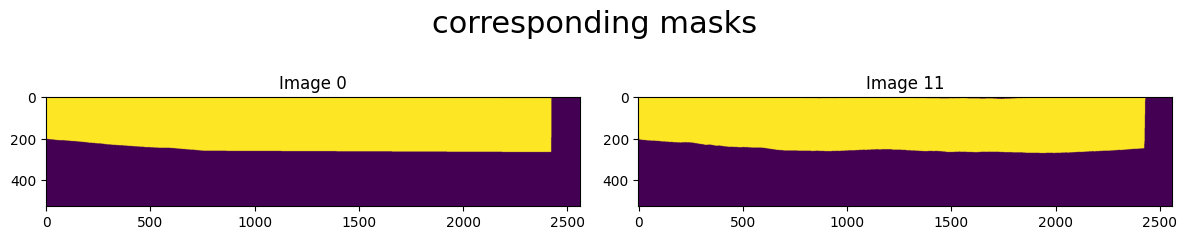

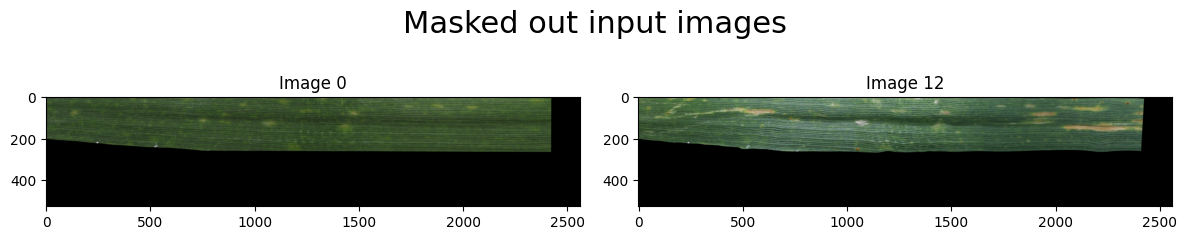

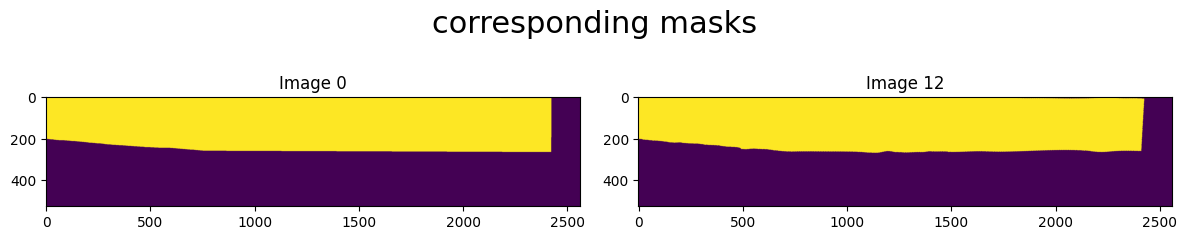

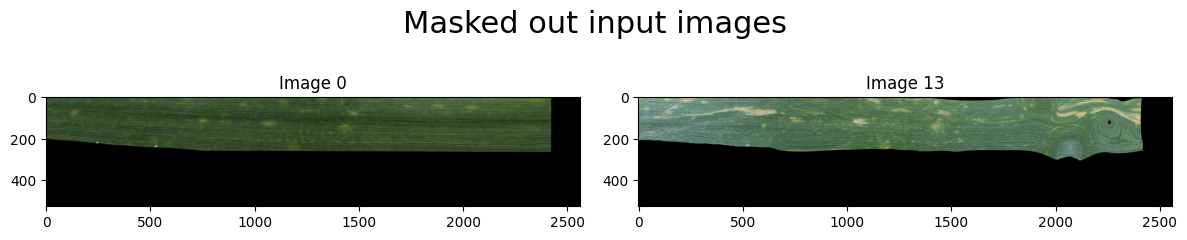

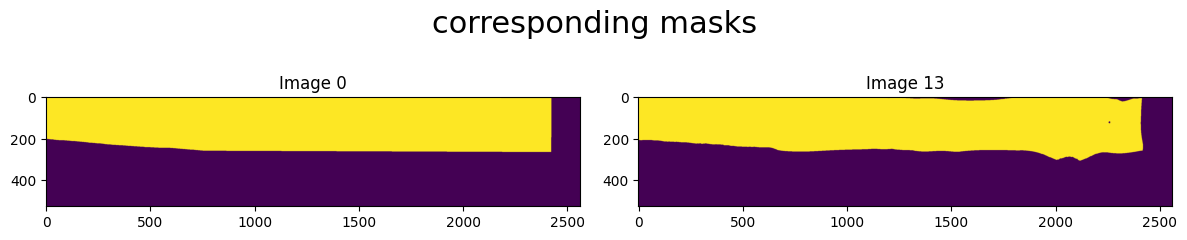

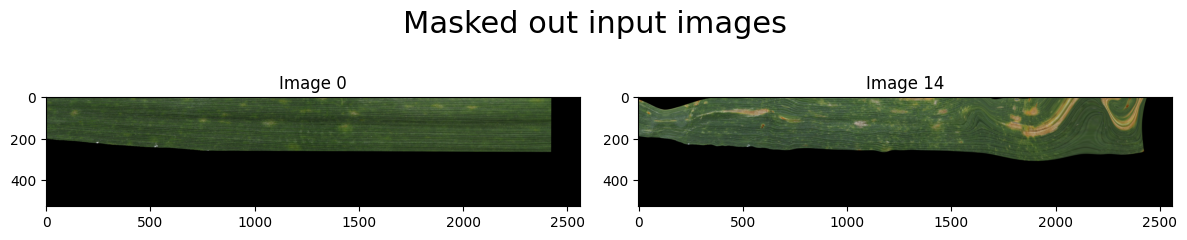

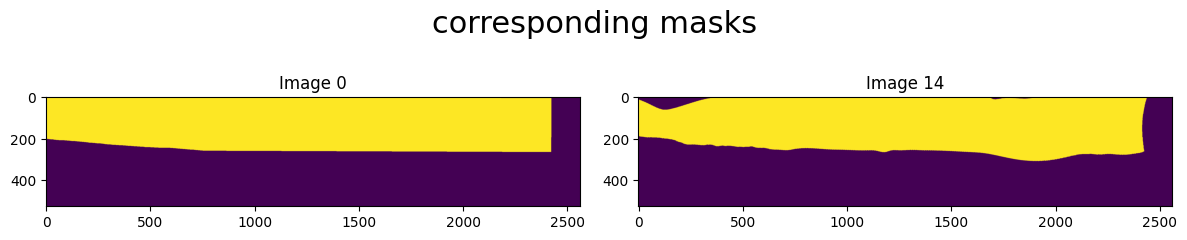

In [33]:
for fixed_img_ind in fixed_img_indices:
    for moving_img_ind in tqdm(moving_img_indices, "Computing Metrics"):

        eval_res = {}

        fixed_img = imgs[fixed_img_ind]
        moving_img = imgs[moving_img_ind]
        fixed_mask = masks[fixed_img_ind]
        moving_mask = masks[moving_img_ind]
        
        if (fixed_img is None) or (moving_img is None) or (fixed_mask is None) or (moving_mask is None):
            print(f"Error: missing data for leaf {uid}")
            # for metric_name, metric_func in metrics.items():
                # eval_res.update({metric_name: None})    
            # writer.writerow(eval_res)
            continue                    
        fig, ax = plot_image_pair(fixed_img, moving_img, fixed_img_ind, moving_img_ind, title="Masked out input images", title_offset=0.7)
        fig.show()
        fig, ax = plot_image_pair(fixed_mask, moving_mask, fixed_img_ind, moving_img_ind, title="corresponding masks", title_offset=0.7)
        fig.show()

        # evaluate for all metrics
        for metric_name, metric_func in metrics.items():
            val = metric_func(fixed_img, fixed_mask, moving_img, moving_mask)
            eval_res.update({metric_name: val.item()})
        print(eval_res)